# Making CMIP6 multimodel means

In [1]:
! pip install --upgrade cmip6_preprocessing

     |████████████████████████████████| 53 kB 659 kB/s eta 0:00:011
  Attempting uninstall: cmip6-preprocessing
    Found existing installation: cmip6-preprocessing 0.1.4
    Uninstalling cmip6-preprocessing-0.1.4:
      Successfully uninstalled cmip6-preprocessing-0.1.4


### Get the CMIP6 catalogue

In [16]:
from intake import open_catalog

cat = open_catalog(
    "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/master.yaml"
)["climate"]["cmip6_gcs"]

In [34]:
# import pprint
instit = cat.unique(["institution_id"])["institution_id"]["values"]
print(instit)

['ECMWF', 'NUIST', 'EC-Earth-Consortium', 'CNRM-CERFACS', 'CAMS', 'E3SM-Project', 'MIROC', 'CSIRO', 'NASA-GISS', 'INM', 'FIO-QLNM', 'MRI', 'MPI-M', 'THU', 'DWD', 'SNU', 'NERC', 'KIOST', 'NOAA-GFDL', 'CAS', 'NCC', 'CSIRO-ARCCSS', 'CCCma', 'CMCC', 'NCAR', 'DKRZ', 'MOHC', 'IPSL', 'NIMS-KMA', 'UA', 'CCCR-IITM', 'HAMMOZ-Consortium', 'AS-RCEC', 'RUBISCO', 'BCC', 'AWI']


In [35]:
print(source_l)

['CESM2-WACCM-FV2', 'UKESM1-0-LL', 'GFDL-OM4p5B', 'EC-Earth3P-HR', 'NorESM1-F', 'AWI-ESM-1-1-LR', 'E3SM-1-1-ECA', 'CanESM5', 'CIESM', 'IITM-ESM', 'MRI-AGCM3-2-H', 'MIROC-ES2H', 'MPI-ESM1-2-LR', 'CMCC-CM2-VHR4', 'HadGEM3-GC31-MM', 'KACE-1-0-G', 'CNRM-CM6-1-HR', 'IPSL-CM6A-LR', 'NorCPM1', 'MCM-UA-1-0', 'EC-Earth3-LR', 'FGOALS-f3-L', 'IPSL-CM6A-ATM-HR', 'EC-Earth3-Veg', 'MIROC-ES2L', 'HadGEM3-GC31-LL', 'CESM1-1-CAM5-CMIP5', 'ECMWF-IFS-HR', 'CAS-ESM2-0', 'BCC-CSM2-HR', 'CMCC-CM2-HR4', 'CESM2-WACCM', 'CMCC-ESM2', 'MPI-ESM1-2-XR', 'GISS-E2-2-G', 'IPSL-CM6A-LR-INCA', 'NESM3', 'TaiESM1', 'MRI-ESM2-0', 'CMCC-CM2-SR5', 'EC-Earth3-CC', 'IPSL-CM5A2-INCA', 'E3SM-1-0', 'SAM0-UNICON', 'INM-CM5-H', 'CanESM5-CanOE', 'AWI-CM-1-1-MR', 'CESM2-FV2', 'CESM1-WACCM-SC', 'BCC-CSM2-MR', 'ECMWF-IFS-LR', 'NorESM2-LM', 'HadGEM3-GC31-HM', 'FGOALS-f3-H', 'FGOALS-g3', 'GISS-E2-1-G', 'CESM2', 'EC-Earth3-AerChem', 'CNRM-ESM2-1', 'GFDL-AM4', 'CNRM-CM6-1', 'E3SM-1-1', 'ACCESS-ESM1-5', 'MIROC6', 'EC-Earth3', 'FIO-ESM-2-0'

In [21]:
source_l = cat.unique(["source_id"])["source_id"]["values"]

In [41]:
failed_list = []; empty_list = []; success_list = []

for i in instit:
    # print(i)
    query = dict(
        variable_id=["clt"],
        experiment_id=["historical"],# , "ssp585"],
        table_id=["Amon"],
        institution_id=[i],
    )
    subset = cat.search(**query)
    z_kwargs = {"consolidated": True, "decode_times": True}
    try:
        with dask.config.set(**{"array.slicing.split_large_chunks": True}):
            dset_dict_proc = subset.to_dataset_dict(zarr_kwargs=z_kwargs,
                                                    preprocess=combined_preprocessing)
            
        
        # print(i, "suceeded")
        if len(dset_dict_proc) == 0:
            empty_list.append(i)
        else:
            success_list.append(i)
            
    except:
        print(i, "failed")
        failed_list.append(i)

/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/srv/conda/envs/


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:286: UserWarning: Found time as dimension in `lat_bounds`. Assuming this is an error and just picking the first step along that dimension.
  warnings.warn(


NCC failed

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/search.py:107: UserWarning: Query returned zero results.
  warn(message)
/srv/conda/envs/notebook/lib/python3.8/site-packages/intake_esm/core.py:890: UserWarning: There are no datasets to load! Returning an empty dictionary.
  warn('There are no datasets to load! Returning an empty dictionary.')



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [42]:
success_list

['NUIST',
 'EC-Earth-Consortium',
 'CNRM-CERFACS',
 'CAMS',
 'E3SM-Project',
 'MIROC',
 'CSIRO',
 'NASA-GISS',
 'INM',
 'FIO-QLNM',
 'MRI',
 'MPI-M',
 'THU',
 'SNU',
 'KIOST',
 'NOAA-GFDL',
 'CAS',
 'CSIRO-ARCCSS',
 'CCCma',
 'CMCC',
 'NCAR',
 'MOHC',
 'IPSL',
 'NIMS-KMA',
 'CCCR-IITM',
 'HAMMOZ-Consortium',
 'AS-RCEC',
 'BCC',
 'AWI']

In [43]:
failed_list

['NCC']

In [44]:
empty_list

['ECMWF', 'DWD', 'NERC', 'DKRZ', 'UA', 'RUBISCO']

In [18]:
query = dict(
        variable_id=["ts"],
        experiment_id=["historical"],# , "ssp585"],
        table_id=["Amon"],
        # institution_id=["NCAR", "NOAA-GFDL", "MOHC", "NASA-GISS", "UA", "INM", "THU", "SNU", "E3SM-Project"],
    )
subset = cat.search(**query)

In [19]:
subset

,unique
activity_id,1
institution_id,31
source_id,62
experiment_id,1
member_id,152
table_id,1
variable_id,1
grid_label,3
zstore,554
dcpp_init_year,0


### Pick out the 60 years mean

In [51]:
import matplotlib.pyplot as plt
import xarray as xr
import dask
from cmip6_preprocessing.preprocessing import (
    rename_cmip6, 
    promote_empty_dims, 
    broadcast_lonlat, 
    replace_x_y_nominal_lat_lon,
    combined_preprocessing,
)

def get_ts(experiment="historical", year_begin="1958", year_end="2014", var="ts", xlim=[100, 290], ylim=[-30, 30]):
    query = dict(
        variable_id=[var],
        experiment_id=[experiment],# , "ssp585"],
        table_id=["Amon"],
        institution_id=[x for x in success_list if x != "AWI"],
    )
    subset = cat.search(**query)

    z_kwargs = {"consolidated": True, "decode_times": True}

    def wrapper(ds):
        ds = ds.copy()
        ds = rename_cmip6(ds)
        ds = promote_empty_dims(ds)
        ds = broadcast_lonlat(ds)
        ds = replace_x_y_nominal_lat_lon(ds)
        return ds

    # pass the preprocessing directly
    with dask.config.set(**{"array.slicing.split_large_chunks": True}):
        dset_dict_proc = subset.to_dataset_dict(zarr_kwargs=z_kwargs,
                                                preprocess=combined_preprocessing)
        
    da_list = []; key_list = []; first = True

    for key in dset_dict_proc:
        print(key)
        da = dset_dict_proc[key][var].mean("member_id").sel(
            x=slice(xlim[0] - 1, xlim[1] + 1), 
            y=slice(ylim[0] - 1, ylim[1] + 1), 
            time=slice(year_begin, year_end)
        ).interp(x=list(range(xlim[0], xlim[1] + 1)), 
                 y=list(range(ylim[0], ylim[1] + 1)))
        key_list.append(key)
        if first:
            times = da.time.values
        da = da.assign_coords(time=list(range(da.sizes["time"])))
        da_list.append(da)
    da = xr.concat(da_list, "model_center")
    da = da.assign_coords({"model_center": key_list, "time": times})
    
    return da

def get_mmm60(var="ts"):
    da_hist = get_ts(xlim=[0, 360], ylim=[-80, 80], var=var)
    da_ssp585 = get_ts(experiment="ssp585", year_begin="2014", year_end="2017", xlim=[0, 360], ylim=[-80, 80], var=var)
    da_comb = xr.concat([da_hist.mean("model_center"), da_ssp585.mean("model_center")], "time")
    da_comb.attrs["hist_list"] = str(da_hist["model_center"].values)
    da_comb.attrs["ssp585_list"] = str(da_ssp585["model_center"].values)
    return da_comb


In [ ]:
clt_60 = get_mmm60("clt")
ts_60 = get_mmm60("ts")
ps_60 = get_mmm60("ps")
pr_60 = get_mmm60("pr")
hur_60 = get_mmm60("hur")
hur_60 = hur_60.bfill("plev").isel(plev=0)

In [10]:
hur_60 = get_mmm60("hur")
hur_60 = hur_60.bfill("plev").isel(plev=0)
hur_60.mean("time").plot()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


CMIP.SNU.SAM0-UNICON.historical.Amon.gn
CMIP.MOHC.HadGEM3-GC31-LL.historical.Amon.gn
CMIP.E3SM-Project.E3SM-1-0.historical.Amon.gr
CMIP.E3SM-Project.E3SM-1-1.historical.Amon.gr
CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn
CMIP.UA.MCM-UA-1-0.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.INM.INM-CM4-8.historical.Amon.gr1
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1
CMIP.NCAR.CESM2-FV2.historical.Amon.gn
CMIP.THU.CIESM.historical.Amon.gr
CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Amon.gr
CMIP.INM.INM-CM5-0.historical.Amon.gr1
CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn
CMIP.MOHC.HadGEM3-GC31-MM.historical.Amon.gn
CMIP.NOAA-GFDL.GFDL-CM4.historical.Amon.gr1
CMIP.NCAR.CESM2-WACCM.historical.Amon.gn
CMIP.NCAR.CESM2.historical.Amon.gn
CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:286: UserWarning: Found time as dimension in `lat_bounds`. Assuming this is an error and just picking the first step along that dimension.
  warnings.warn(


ScenarioMIP.E3SM-Project.E3SM-1-1.ssp585.Amon.gr
ScenarioMIP.MOHC.HadGEM3-GC31-LL.ssp585.Amon.gn
ScenarioMIP.INM.INM-CM5-0.ssp585.Amon.gr1
ScenarioMIP.MOHC.HadGEM3-GC31-MM.ssp585.Amon.gn
ScenarioMIP.NCAR.CESM2-WACCM.ssp585.Amon.gn
ScenarioMIP.INM.INM-CM4-8.ssp585.Amon.gr1
ScenarioMIP.NOAA-GFDL.GFDL-CM4.ssp585.Amon.gr1
ScenarioMIP.NOAA-GFDL.GFDL-ESM4.ssp585.Amon.gr1
ScenarioMIP.NCAR.CESM2.ssp585.Amon.gn
ScenarioMIP.THU.CIESM.ssp585.Amon.gr
ScenarioMIP.UA.MCM-UA-1-0.ssp585.Amon.gn
ScenarioMIP.MOHC.UKESM1-0-LL.ssp585.Amon.gn
ScenarioMIP.NASA-GISS.GISS-E2-1-G.ssp585.Amon.gn


KeyboardInterrupt: 

In [ ]:
import os

def run_through() -> None:
    """Run through."""
    for i in ["clt", "ts", "ps", "pr"]: # ,# "hur"]:
        if i == "hur":
            mmm_60 = get_mmm60("hur").isel(plev=0).rename("rh") 
            # .isel(plev=slice(0, 3)).bfill("plev").isel(plev=0).rename("rh")
            mmm_60.to_netcdf(os.path.join("nc", "rh-CMIP6-clim60.nc"))
        else:
            mmm_60 = get_mmm60(i)
            mmm_60.to_netcdf(os.path.join("nc", i + "-CMIP6-clim60.nc"))

run_through()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:267: UserWarning: `FGOALS-f3-L` does not provide lon or lat bounds.
  warnings.warn("`FGOALS-f3-L` does not provide lon or lat bounds.")
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = blockwise(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:4225: PerformanceWarning: Increasing number of chunks by factor of 16
  result = bl

CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn
CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn
CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn
CMIP.BCC.BCC-ESM1.historical.Amon.gn
CMIP.EC-Earth-Consortium.EC-Earth3-CC.historical.Amon.gr
CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn
CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn
CMIP.CCCma.CanESM5-CanOE.historical.Amon.gn
CMIP.MOHC.UKESM1-0-LL.historical.Amon.gn
CMIP.INM.INM-CM4-8.historical.Amon.gr1
CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Amon.gr
CMIP.INM.INM-CM5-0.historical.Amon.gr1
CMIP.CSIRO.ACCESS-ESM1-5.historical.Amon.gn
CMIP.NOAA-GFDL.GFDL-ESM4.historical.Amon.gr1
CMIP.THU.CIESM.historical.Amon.gr
CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn
CMIP.EC-Earth-Consortium.EC-Earth3-Veg-LR.historical.Amon.gr
CMIP.CAS.FGOALS-f3-L.historical.Amon.gr
CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn
CMIP.EC-Earth-Consortium.EC-Earth3-AerChem.historical.Amon.gr
CMIP.NIMS-KMA.UKESM1-0-LL.historical.Amon.gn
CMIP.FIO-QLNM.FIO-ESM-2-0.historical.Amon.gn
CMIP.C

/srv/conda/envs/notebook/lib/python3.8/site-packages/cmip6_preprocessing/preprocessing.py:286: UserWarning: Found time as dimension in `lat_bounds`. Assuming this is an error and just picking the first step along that dimension.
  warnings.warn(


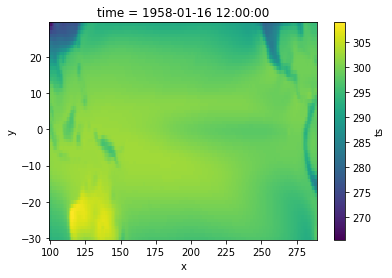

In [4]:
combined_da_60.isel(time=0).plot()

In [6]:
combined_da_60.isel(time=0).to_netcdf("test1958.nc")

In [8]:
combined_da_60.mean("time").to_netcdf("ts-CMIP6-clim60.nc")

In [3]:
xr.open_dataarray("ts-CMIP6-clim60.nc")

<xarray.DataArray 'ts' (y: 160, x: 360)>
array([[231.15431, 231.98521, 231.63889, ..., 233.7208 , 233.34308, 233.98206],
       [231.52324, 231.9984 , 231.4507 , ..., 233.8675 , 233.49916, 234.05464],
       [231.68129, 231.96329, 231.2421 , ..., 233.8911 , 233.43497, 234.01778],
       ...,
       [269.8629 , 270.4461 , 270.65076, ..., 266.46286, 267.34332, 268.3447 ],
       [267.52377, 268.2427 , 268.60956, ..., 264.23926, 265.03806, 265.98547],
       [265.2135 , 265.3309 , 265.8335 , ..., 262.19775, 262.72098, 263.19543]],
      dtype=float32)
Coordinates:
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 351 352 353 354 355 356 357 358 359
  * y        (y) int64 -80 -79 -78 -77 -76 -75 -74 -73 ... 73 74 75 76 77 78 79

In [5]:
xr.open_dataarray("ts-CMIP6-clim60.nc").to_netcdf("ts-CMIP6-3-clim60.nc", format="NETCDF3_CLASSIC")

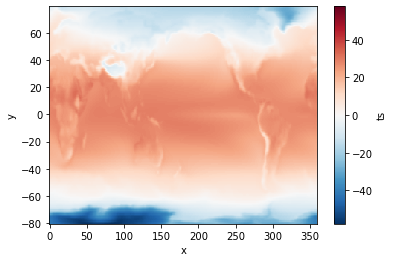

In [7]:
(xr.open_dataarray("ts-CMIP6-clim60.nc") - 273.15).plot()